In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU Runtime Detected")

else:
  device = torch.device("cpu")
  print("No GPU Found - CPU Runtime")

No GPU Found - CPU Runtime


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amirberenji/thermal-images-of-induction-motor")


In [ ]:
base_dir = path
folders_of_interest = os.listdir(base_dir)
folders_of_interest.remove('Read me.txt')
folders_of_interest

['Fan',
 'A&C10',
 'A&B50',
 'A&C30',
 'Noload',
 'Rotor-0',
 'A&C&B30',
 'A30',
 'A&C&B10',
 'A50',
 'A10']

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

images = []
labels = []

for folder in folders_of_interest:
    folder_path = os.path.join(base_dir, folder)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        try:
            image = Image.open(img_path).resize((60, 80)).convert('RGB')
            images.append(np.array(image))
            labels.append([folder, img])
        except Exception as e:
            print(f"Skipped {img_path} due to error: {e}")

images = np.array(images)
labels = pd.DataFrame(labels, columns=['state', 'IMG Name'])

print(images.shape, labels.shape)


(369, 80, 60, 3) (369, 2)


In [ ]:
images = images / 255

In [ ]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(labels['state'])
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
yy = list(y)
y0 = yy.count(0)
y1 = yy.count(1)
y2 = yy.count(2)
y3 = yy.count(3)
y4 = yy.count(4)
y5 = yy.count(5)
y6 = yy.count(6)
y7 = yy.count(7)
y8 = yy.count(8)
y9 = yy.count(9)
y10 = yy.count(10)
print(y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10)

38 31 42 31 38 34 37 35 28 25 30


In [ ]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(images, y, test_size = 0.1,random_state = 42,stratify=y)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(332, 80, 60, 3) (332,)
(37, 80, 60, 3) (37,)


In [ ]:
yy = list(y_test)
y0 = yy.count(0)
y1 = yy.count(1)
y2 = yy.count(2)
y3 = yy.count(3)
y4 = yy.count(4)
y5 = yy.count(5)
y6 = yy.count(6)
y7 = yy.count(7)
y8 = yy.count(8)
y9 = yy.count(9)
y10 = yy.count(10)
print(y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10)

4 3 4 3 4 3 4 4 3 2 3


#Supervised CNN

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 10)
        self.conv2 = torch.nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 10)
        self.avgPool = torch.nn.AvgPool2d(10)
        self.fc1 = torch.nn.Linear(480, 100)
        self.fc2 = torch.nn.Linear(100, 11)

    def forward(self, x):

        z = torch.tanh(self.conv1(x))
        z = torch.tanh(self.conv2(z))
        z = self.avgPool(z).reshape(-1, 480)
        z = torch.tanh(self.fc1(z))
        z = self.fc2(z)

        return z

In [ ]:
x_train_train, x_train_validation, y_train_train, y_train_validation = train_test_split(x_train, y_train, test_size = 0.1, random_state = 10)

x_train_train, x_train_validation = x_train_train.transpose([0, 3, 1, 2]), x_train_validation.transpose([0, 3, 1, 2])

x_train_VAR = torch.autograd.Variable(torch.Tensor(x_train_train).float()).to(device)
y_train_VAR = torch.autograd.Variable(torch.LongTensor(y_train_train)).to(device)
x_valid_VAR = torch.autograd.Variable(torch.Tensor(x_train_validation).float()).to(device)
y_valid_VAR = torch.autograd.Variable(torch.LongTensor(y_train_validation)).to(device)

In [ ]:
lr = 0.0005
ep = 1000

model = Classifier().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr,
                             weight_decay = lr / ep)

losses = []
valid_losses = []
accs = []
valid_accs = []



for epoch in range(ep):

  # validation step
  valid_loss = criterion(model(x_valid_VAR), y_valid_VAR).item()
  valid_losses.append(valid_loss)
  valid_acc = accuracy_score(y_train_validation, np.argmax(model(x_valid_VAR).cpu().detach().numpy(), axis = 1))
  valid_accs.append(valid_acc)

  # training step
  optimizer.zero_grad()
  loss = criterion(model(x_train_VAR), y_train_VAR)
  acc = accuracy_score(y_train_train, np.argmax(model(x_train_VAR).cpu().detach().numpy(), axis = 1))
  accs.append(acc)
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  print(f"Epoch {epoch+1}, loss: {np.round(loss.item(), 4)}  , Vloss: {np.round(valid_loss, 4)}, acc: {np.round(acc, 4)}, Vacc: {np.round(valid_acc, 4)}")

Epoch 1, loss: 2.401  , Vloss: 2.3943, acc: 0.1342, Vacc: 0.0588
Epoch 2, loss: 2.3661  , Vloss: 2.3568, acc: 0.1174, Vacc: 0.1471
Epoch 3, loss: 2.3283  , Vloss: 2.3157, acc: 0.1107, Vacc: 0.1471
Epoch 4, loss: 2.2788  , Vloss: 2.2627, acc: 0.2047, Vacc: 0.2353
Epoch 5, loss: 2.2143  , Vloss: 2.1952, acc: 0.302, Vacc: 0.3824
Epoch 6, loss: 2.1365  , Vloss: 2.1159, acc: 0.302, Vacc: 0.3824
Epoch 7, loss: 2.0522  , Vloss: 2.0321, acc: 0.2047, Vacc: 0.2353
Epoch 8, loss: 1.9711  , Vloss: 1.9545, acc: 0.2047, Vacc: 0.2353
Epoch 9, loss: 1.9014  , Vloss: 1.892, acc: 0.2047, Vacc: 0.2353
Epoch 10, loss: 1.8435  , Vloss: 1.8443, acc: 0.2047, Vacc: 0.2647
Epoch 11, loss: 1.7921  , Vloss: 1.8037, acc: 0.302, Vacc: 0.3824
Epoch 12, loss: 1.7444  , Vloss: 1.7646, acc: 0.3188, Vacc: 0.4118
Epoch 13, loss: 1.7009  , Vloss: 1.7258, acc: 0.3926, Vacc: 0.4412
Epoch 14, loss: 1.662  , Vloss: 1.6877, acc: 0.443, Vacc: 0.4706
Epoch 15, loss: 1.6271  , Vloss: 1.6506, acc: 0.5302, Vacc: 0.4706
Epoch 16, l

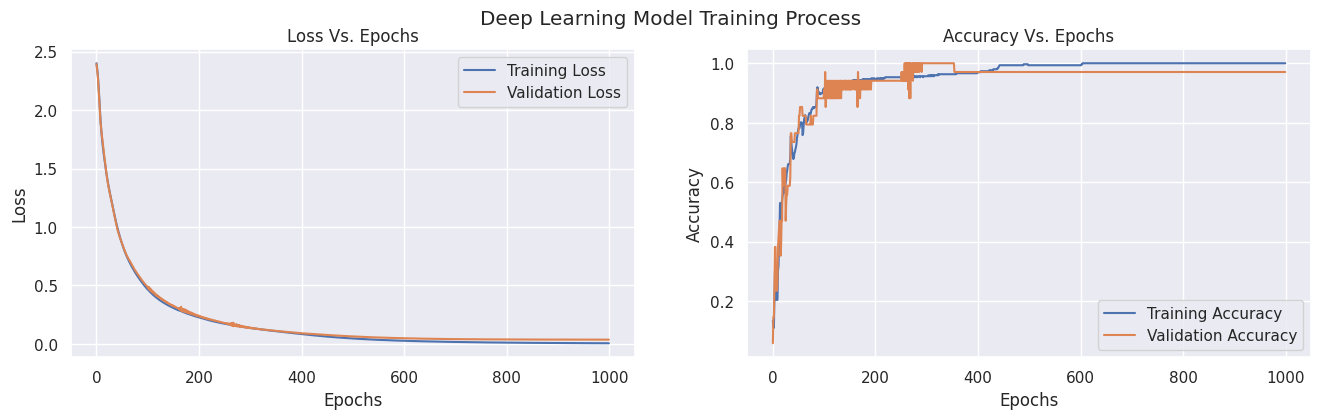

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))
fig.suptitle('Deep Learning Model Training Process')
axes[0].plot(losses, label='Training Loss')
axes[0].plot(valid_losses, label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Vs. Epochs')
axes[0].legend()

axes[1].plot(accs, label='Training Accuracy')
axes[1].plot(valid_accs, label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Vs. Epochs')
axes[1].legend()
plt.show()

In [ ]:
x_test_VAR = torch.autograd.Variable(torch.Tensor(x_test.transpose([0, 3, 1, 2]))).to(device)
testing_acc = accuracy_score(y_test, np.argmax(F.softmax(model(x_test_VAR), dim = 0).cpu().detach().numpy(), axis = 1))
print('Held-out Test-set Accuracy: ', round(testing_acc, 4))

Held-out Test-set Accuracy:  1.0


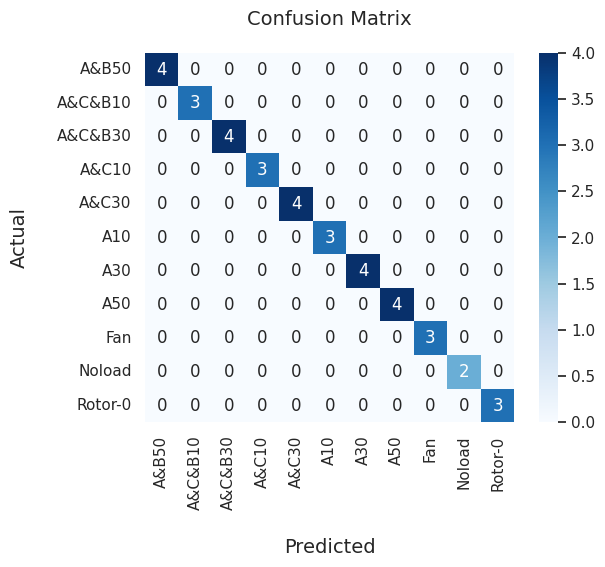

In [ ]:
y_test_pred = np.argmax(F.softmax(model(x_test_VAR), dim = 0).cpu().detach().numpy(), axis = 1)
y_test_pred_decoded = labelencoder.inverse_transform(y_test_pred)

matrix = confusion_matrix(y_test, y_test_pred)

ax = sns.heatmap(matrix, annot=True, fmt='d', cbar = True, square = True, cmap = 'Blues')
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(np.unique(y_test_pred_decoded))
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(np.unique(y_test_pred_decoded))

plt.yticks(rotation=360)
plt.xticks(rotation=90)

ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()

In [ ]:
num_class = len(np.unique(y))

#Semisupervised AE

Streaming output truncated to the last 5000 lines.
  Train Accuracy: 0.1515

Epoch 287/1000
  Total Loss: 0.0004
  Recon Loss (Labeled): 0.0000
  Recon Loss (Unlabeled): 0.0000
  Classification Loss: 0.0008
  Train Accuracy: 0.1515

Epoch 288/1000
  Total Loss: 0.0004
  Recon Loss (Labeled): 0.0000
  Recon Loss (Unlabeled): 0.0000
  Classification Loss: 0.0008
  Train Accuracy: 0.1818

Epoch 289/1000
  Total Loss: 0.0004
  Recon Loss (Labeled): 0.0000
  Recon Loss (Unlabeled): 0.0000
  Classification Loss: 0.0008
  Train Accuracy: 0.2121

Epoch 290/1000
  Total Loss: 0.0004
  Recon Loss (Labeled): 0.0000
  Recon Loss (Unlabeled): 0.0000
  Classification Loss: 0.0008
  Train Accuracy: 0.2121

Epoch 291/1000
  Total Loss: 0.0004
  Recon Loss (Labeled): 0.0000
  Recon Loss (Unlabeled): 0.0000
  Classification Loss: 0.0008
  Train Accuracy: 0.2424

Epoch 292/1000
  Total Loss: 0.0004
  Recon Loss (Labeled): 0.0000
  Recon Loss (Unlabeled): 0.0000
  Classification Loss: 0.0008
  Train Accur

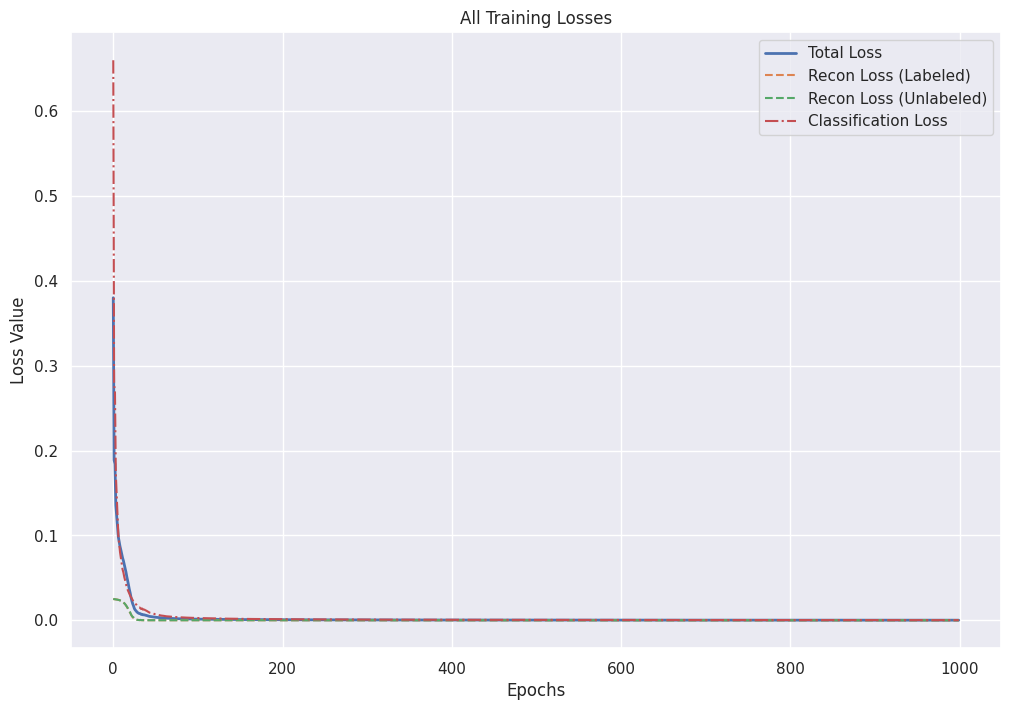

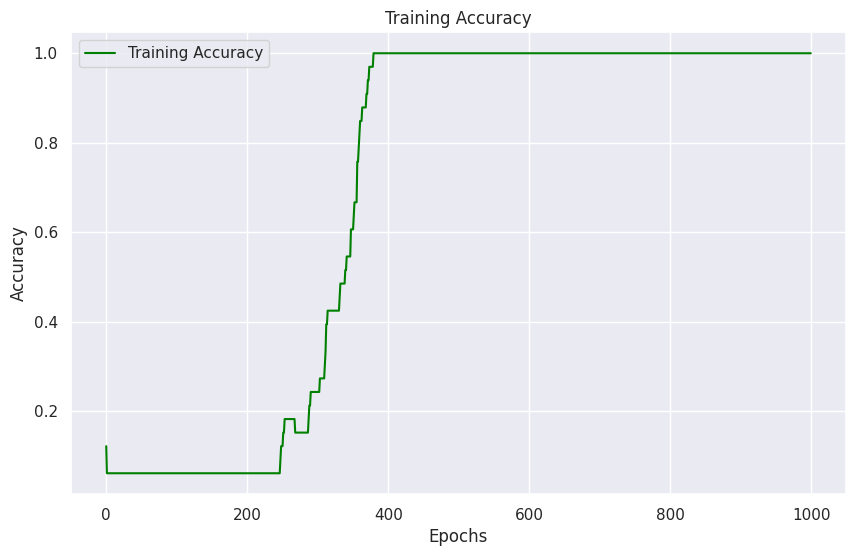

Test Accuracy: 0.9459


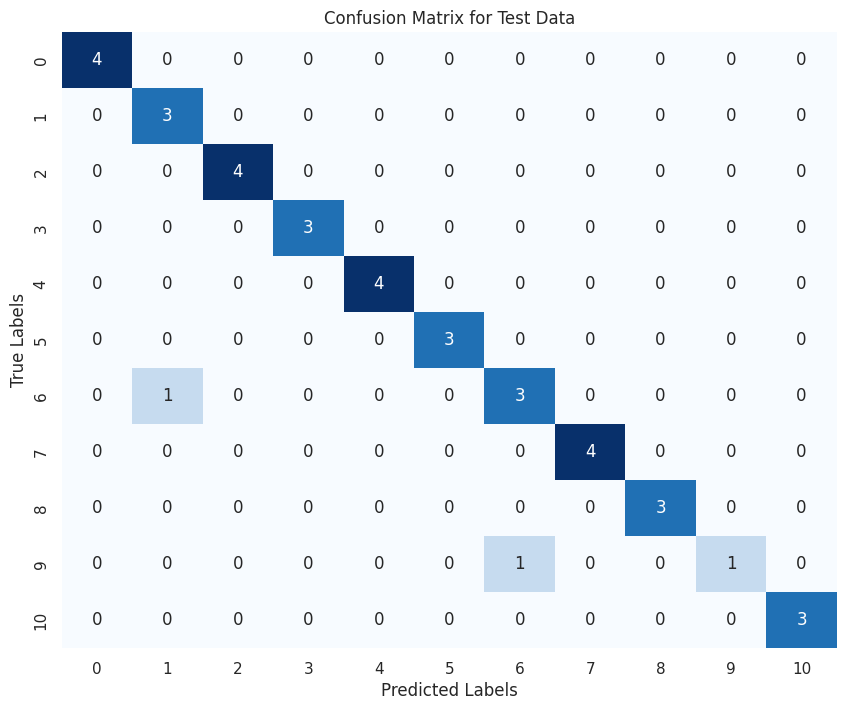

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)
num_class = len(np.unique(y_train))


X_train = x_train.astype('float32') / 255.
X_test = x_test.astype('float32') / 255.
y_train = y_train
y_test = y_test


num_labeled = int(0.1 * len(X_train))
idx = np.random.choice(len(X_train), num_labeled, replace=False)
X_labeled = X_train[idx]
y_labeled = y_train[idx]
'''
n_per_class = 3
selected_indices = []

for class_label in np.unique(y_train):
    class_indices = np.where(y_train == class_label)[0]

    if len(class_indices) < n_per_class:
        raise ValueError(f"class{class_label} only{len(class_indices)} sampels hs!")

    chosen = np.random.choice(class_indices, n_per_class, replace=False)
    selected_indices.extend(chosen)

selected_indices = np.array(selected_indices)

X_labeled = X_train[selected_indices]
y_labeled = y_train[selected_indices]
'''

def build_encoder():
    input_img = layers.Input(shape=(80, 60, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)
    encoded = layers.BatchNormalization()(x)
    #encoded = layers.Dropout(0.05)(x)
    return models.Model(input_img, encoded, name="Encoder")

def build_decoder():
    encoded_input = layers.Input(shape=(128,))
    x = layers.Dense(20 * 15 * 64, activation='relu')(encoded_input)
    x = layers.Reshape((20, 15, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same' ,kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same' ,kernel_regularizer=regularizers.l2(0.001))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
    return models.Model(encoded_input, decoded, name="Decoder")

def build_classifier():
    encoded_input = layers.Input(shape=(128,))
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(encoded_input)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(num_class, activation='softmax', kernel_regularizer=regularizers.l2(0.0005))(x)
    #output = layers.Dropout(0.2)(x)
    return models.Model(encoded_input, output, name="Classifier")


encoder = build_encoder()
decoder = build_decoder()
classifier = build_classifier()

input_img = layers.Input(shape=(80, 60, 3))
encoded = encoder(input_img)
reconstructed = decoder(encoded)
class_output = classifier(encoded)

full_model = models.Model(input_img, [reconstructed, class_output])


reconstruction_loss_fn = tf.keras.losses.Huber()
classification_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

@tf.function
def train_step(x_labeled, y_labeled, x_unlabeled):
    with tf.GradientTape() as tape:

        encoded_labeled = encoder(x_labeled, training=True)
        reconstructed_labeled = decoder(encoded_labeled, training=True)
        class_pred_labeled = classifier(encoded_labeled, training=True)


        encoded_unlabeled = encoder(x_unlabeled, training=True)
        reconstructed_unlabeled = decoder(encoded_unlabeled, training=True)


        reconstruction_loss_labeled = reconstruction_loss_fn(x_labeled, reconstructed_labeled)
        classification_loss = classification_loss_fn(y_labeled, class_pred_labeled)
        reconstruction_loss_unlabeled = reconstruction_loss_fn(x_unlabeled, reconstructed_unlabeled)


        total_loss = reconstruction_loss_unlabeled + reconstruction_loss_labeled + 0.5*classification_loss


    gradients = tape.gradient(total_loss, full_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, full_model.trainable_variables))

    return (total_loss,
            reconstruction_loss_labeled,
            reconstruction_loss_unlabeled,
            classification_loss)


batch_size = 64
epochs = 1000


total_losses = []
rec_losses_labeled = []
rec_losses_unlabeled = []
class_losses = []
train_accuracies = []

for epoch in range(epochs):
    idx_unlabeled = np.random.permutation(len(X_train))
    idx_labeled = np.random.permutation(len(X_labeled))
    X_train_unlabeled = X_train[idx_unlabeled]
    X_train_labeled = X_labeled[idx_labeled]
    y_train_labeled = y_labeled[idx_labeled]

    n_batches = len(X_train_unlabeled) // batch_size


    epoch_total_loss = 0.0
    epoch_rec_loss_labeled = 0.0
    epoch_rec_loss_unlabeled = 0.0
    epoch_class_loss = 0.0

    for i in range(n_batches):
        batch_unlabeled = X_train_unlabeled[i*batch_size:(i+1)*batch_size]
        batch_labeled = X_train_labeled[i*batch_size:(i+1)*batch_size]
        batch_labels = y_train_labeled[i*batch_size:(i+1)*batch_size]

        if batch_labeled.shape[0] == 0:
            continue


        losses = train_step(batch_labeled, batch_labels, batch_unlabeled)
        total_loss, rec_loss_labeled, rec_loss_unlabeled, class_loss = losses


        epoch_total_loss += total_loss.numpy()
        epoch_rec_loss_labeled += rec_loss_labeled.numpy()
        epoch_rec_loss_unlabeled += rec_loss_unlabeled.numpy()
        epoch_class_loss += class_loss.numpy()


    avg_total_loss = epoch_total_loss / n_batches
    avg_rec_loss_labeled = epoch_rec_loss_labeled / n_batches
    avg_rec_loss_unlabeled = epoch_rec_loss_unlabeled / n_batches
    avg_class_loss = epoch_class_loss / n_batches


    total_losses.append(avg_total_loss)
    rec_losses_labeled.append(avg_rec_loss_labeled)
    rec_losses_unlabeled.append(avg_rec_loss_unlabeled)
    class_losses.append(avg_class_loss)


    labeled_pred = classifier(encoder(X_labeled, training=False), training=False)
    labeled_pred_labels = tf.argmax(labeled_pred, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(labeled_pred_labels, y_labeled), tf.float32))
    train_accuracies.append(accuracy.numpy())


    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Total Loss: {avg_total_loss:.4f}")
    print(f"  Recon Loss (Labeled): {avg_rec_loss_labeled:.4f}")
    print(f"  Recon Loss (Unlabeled): {avg_rec_loss_unlabeled:.4f}")
    print(f"  Classification Loss: {avg_class_loss:.4f}")
    print(f"  Train Accuracy: {accuracy.numpy():.4f}\n")


plt.figure(figsize=(12, 8))
plt.plot(total_losses, label='Total Loss', linewidth=2)
plt.plot(rec_losses_labeled, label='Recon Loss (Labeled)', linestyle='--')
plt.plot(rec_losses_unlabeled, label='Recon Loss (Unlabeled)', linestyle='--')
plt.plot(class_losses, label='Classification Loss', linestyle='-.')
plt.title('All Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


encoded_test = encoder(X_test, training=False)
class_pred_test = classifier(encoded_test, training=False)
y_pred_labels = np.argmax(class_pred_test.numpy(), axis=1)


test_accuracy = np.mean(y_pred_labels == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Data')
plt.show()

In [ ]:
y_labeled

array([ 2,  3,  1, 10,  7,  2,  9,  2,  0,  2, 10,  7,  8,  9,  4,  0,  6,
        1,  5,  6,  1,  8,  6,  7,  2,  5,  3,  6,  0,  1,  4,  0,  9])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/85 - Labeled Train Accuracy: 0.1515 - Loss: 2.3615
Epoch 2/85 - Labeled Train Accuracy: 0.1515 - Loss: 2.4094
Epoch 3/85 - Labeled Train Accuracy: 0.1515 - Loss: 2.3927
Epoch 4/85 - Labeled Train Accuracy: 0.2727 - Loss: 2.2971
Epoch 5/85 - Labeled Train Accuracy: 0.2727 - Loss: 2.0555
Epoch 6/85 - Labeled Train Accuracy: 0.2727 - Loss: 1.8698
Epoch 7/85 - Labeled Train Accuracy: 0.2727 - Loss: 1.9571
Epoch 8/85 - Labeled Train Accuracy: 0.2424 - Loss: 1.8401
Epoch 9/85 - Labeled Train Accuracy: 0.3030 - Loss: 1.5751
Epoch 10/85 - Labeled Train Accuracy: 0.2727 - Loss: 1.5730
Epoch 11/85 - Labeled Train Accuracy: 0.3333 - Loss: 1.4774
Epoch 12/85 - Labeled Train Accuracy: 0.3636 - Loss: 1.6694
Epoch 13/85 - Labeled Train Accuracy: 0.3333 - Loss: 1.4525
Epoch 14/85 - Labeled Train Accuracy: 0.5455 - Loss: 1.1720
Epoch 15/85 - Labeled Train Accuracy: 0.4848 - Loss: 1.0980
Epoch 16/85 - Labeled Train Accuracy: 0.6667 - Loss: 1.1456
Epoch 17/85 - Labeled Train Accuracy: 0.6061 - Lo

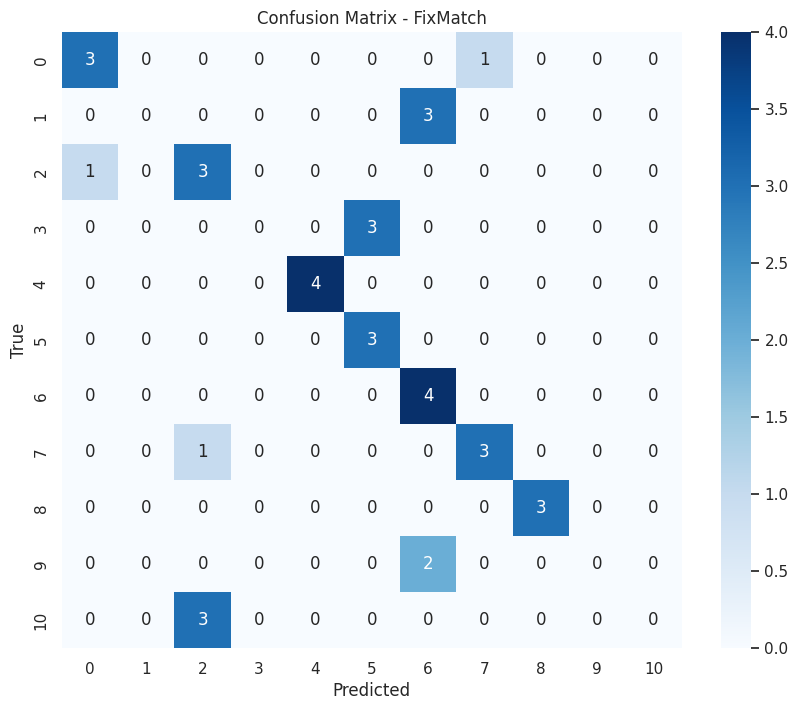

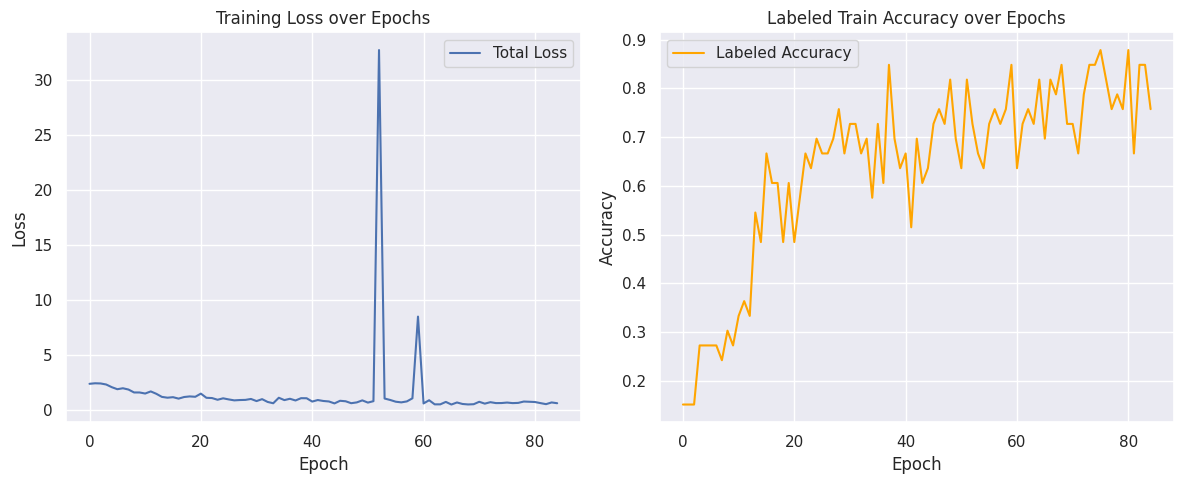

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)



num_class = len(np.unique(y_train))

X_train = x_train.astype('float32') / 255.
X_test = x_test.astype('float32') / 255.
y_train = y_train
y_test = y_test

num_labeled = int(0.1 * len(X_train))
idx = np.random.choice(len(X_train), num_labeled, replace=False)
X_labeled = X_train[idx]
y_labeled = y_train[idx]
X_unlabeled = np.delete(X_train, idx, axis=0)
'''
n_per_class = 3
selected_indices = []

for class_label in np.unique(y_train):
    class_indices = np.where(y_train == class_label)[0]

    if len(class_indices) < n_per_class:
        raise ValueError(f"class{class_label} only{len(class_indices)} sampels hs!")

    chosen = np.random.choice(class_indices, n_per_class, replace=False)
    selected_indices.extend(chosen)

selected_indices = np.array(selected_indices)

X_labeled = X_train[selected_indices]
y_labeled = y_train[selected_indices]
'''
def weak_augmentation(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    return image

def strong_augmentation(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.3)
    image = tf.image.random_contrast(image, 0.6, 1.4)
    image = tf.image.random_saturation(image, 0.6, 1.4)
    return image


def build_model(input_shape, num_class):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_class, activation='softmax')
    ])
    return model

model = build_model(X_train.shape[1:], num_class)
optimizer = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
batch_size = 32
epochs = 85

train_losses = []
train_accuracies = []


for epoch in range(epochs):
    idx_unlab = np.random.permutation(len(X_unlabeled))
    n_batches = len(idx_unlab) // batch_size

    for i in range(n_batches):
        unlab_batch = X_unlabeled[idx_unlab[i * batch_size: (i + 1) * batch_size]]

        weak_imgs = tf.stack([weak_augmentation(img) for img in unlab_batch])
        strong_imgs = tf.stack([strong_augmentation(img) for img in unlab_batch])

        preds = model(weak_imgs, training=False)
        pseudo_labels = tf.argmax(preds, axis=1)
        confidences = tf.reduce_max(preds, axis=1)

        mask = confidences >= 0.95
        strong_imgs_conf = tf.boolean_mask(strong_imgs, mask)
        pseudo_labels_conf = tf.boolean_mask(pseudo_labels, mask)

        idx_lab = np.random.choice(len(X_labeled), batch_size, replace=True)
        x_lab = X_labeled[idx_lab]
        y_lab = y_labeled[idx_lab]

        with tf.GradientTape() as tape:
            pred_lab = model(x_lab, training=True)
            loss_lab = loss_fn(y_lab, pred_lab)

            if tf.shape(strong_imgs_conf)[0] > 0:
                pred_unlab = model(strong_imgs_conf, training=True)
                loss_unlab = loss_fn(pseudo_labels_conf, pred_unlab)
            else:
                loss_unlab = 0.0

            total_loss = loss_lab + loss_unlab

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))


    pred_train = model.predict(X_labeled, verbose=0)
    acc = np.mean(np.argmax(pred_train, axis=1) == y_labeled)
    train_losses.append(total_loss.numpy())
    train_accuracies.append(acc)

    print(f"Epoch {epoch + 1}/{epochs} - Labeled Train Accuracy: {acc:.4f} - Loss: {total_loss:.4f}")

pred_test = model.predict(X_test, verbose=0)
y_pred = np.argmax(pred_test, axis=1)
test_acc = np.mean(y_pred == y_test)
print(f"Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - FixMatch")
plt.show()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Labeled Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Labeled Train Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

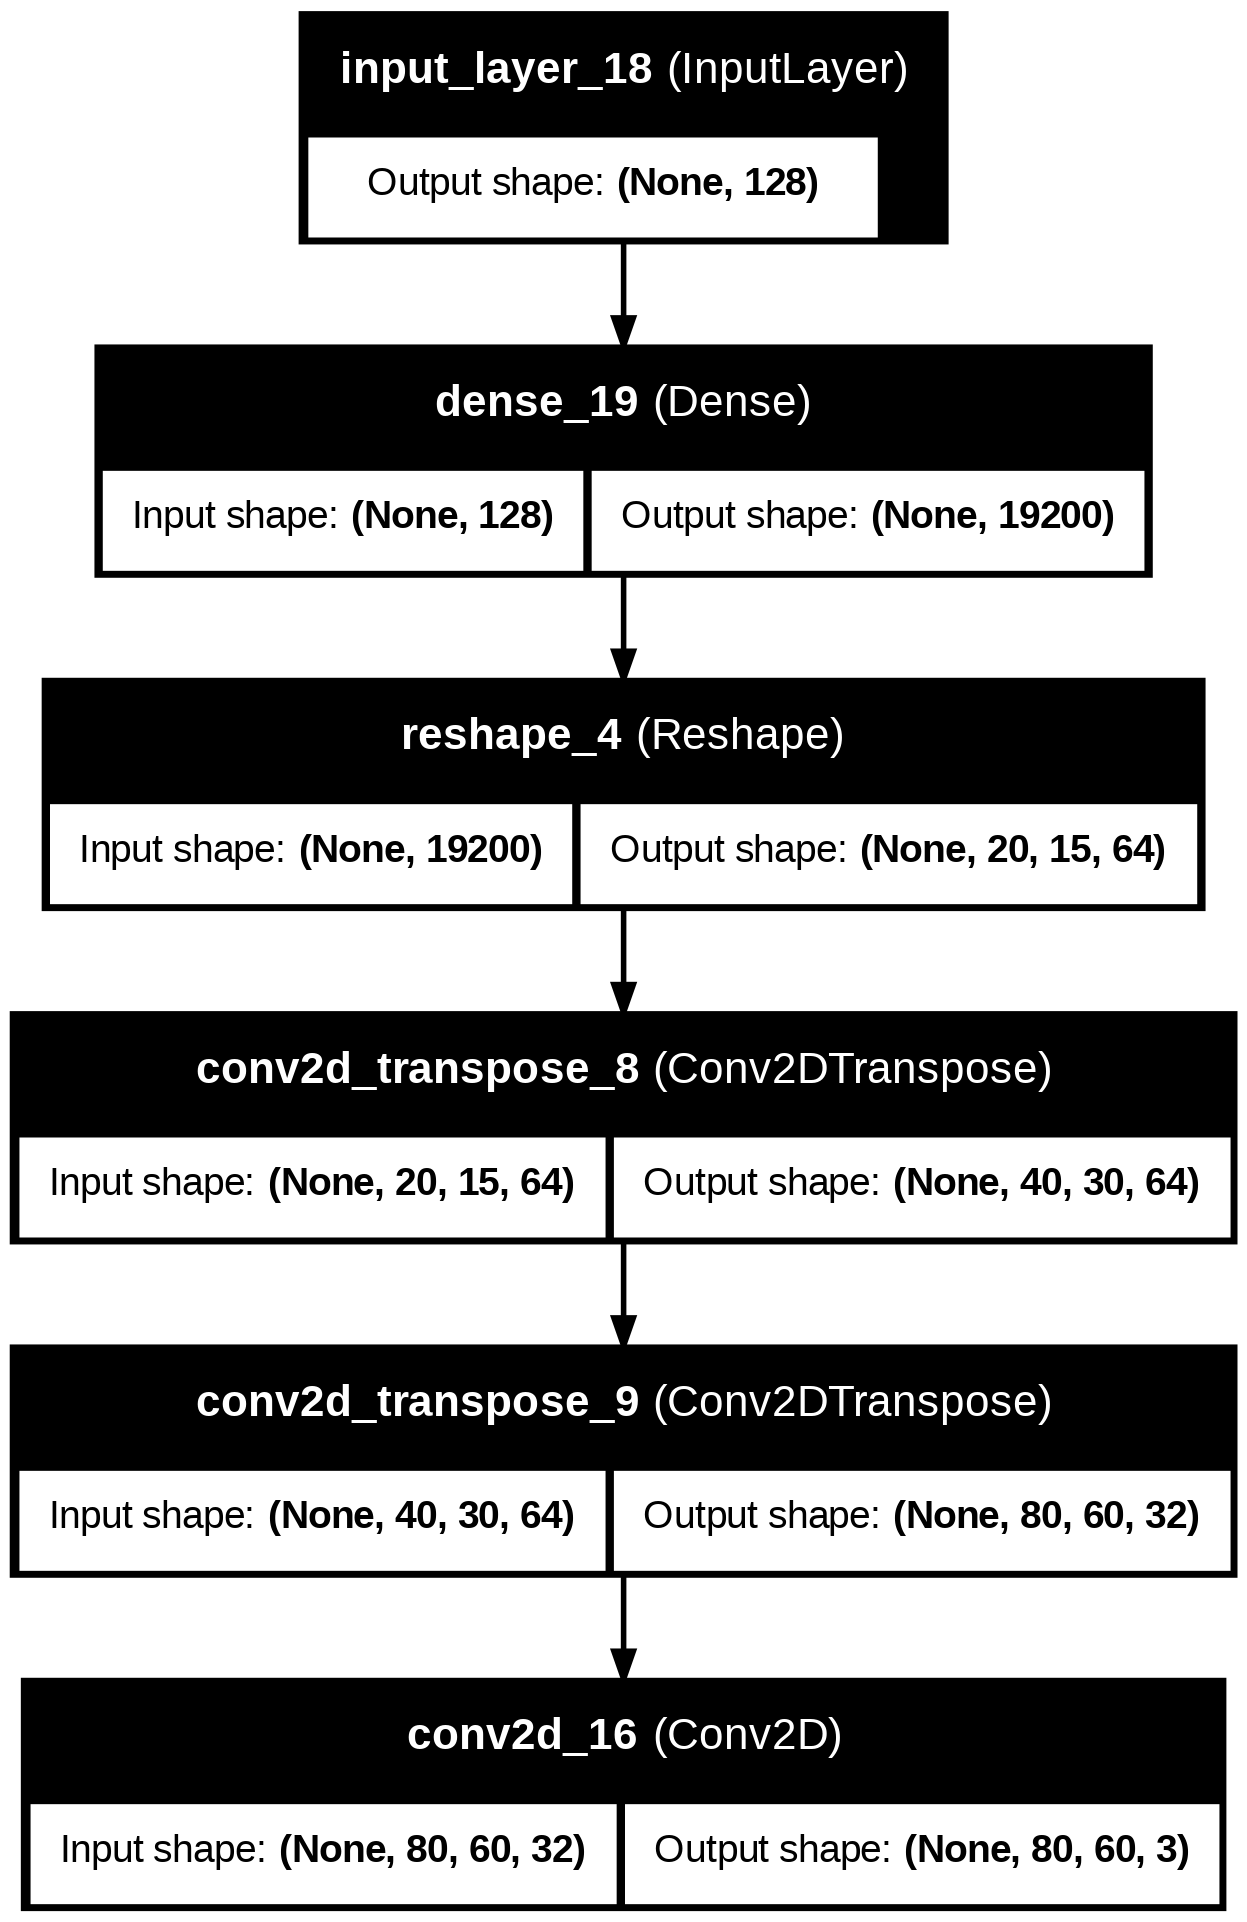

In [ ]:
from tensorflow.keras.utils import plot_model

def build_encoder():
    input_img = layers.Input(shape=(80, 60, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)
    encoded = layers.BatchNormalization()(x)
    #encoded = layers.Dropout(0.05)(x)
    return models.Model(input_img, encoded, name="Encoder")

def build_decoder():
    encoded_input = layers.Input(shape=(128,))
    x = layers.Dense(20 * 15 * 64, activation='relu')(encoded_input)
    x = layers.Reshape((20, 15, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same' ,kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same' ,kernel_regularizer=regularizers.l2(0.001))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
    return models.Model(encoded_input, decoded, name="Decoder")
encoder = build_encoder()
decoder = build_decoder()

plot_model(decoder, to_file='encoder_model.png', show_shapes=True, show_layer_names=True)

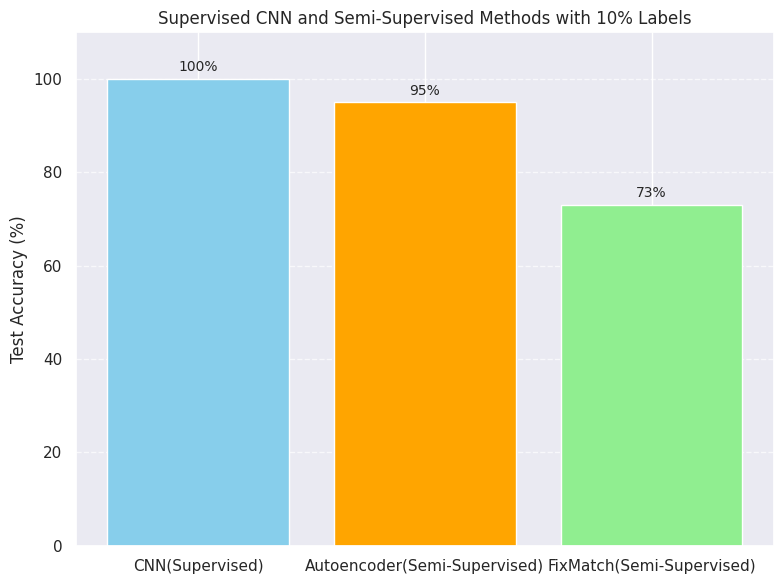

In [ ]:
import matplotlib.pyplot as plt

# Method names and their corresponding accuracies
methods = ['CNN(Supervised)', 'Autoencoder(Semi-Supervised)', 'FixMatch(Semi-Supervised)']
accuracies = [100, 95, 73]

# Set figure size
plt.figure(figsize=(8, 6))

# Create bar chart
bars = plt.bar(methods, accuracies, color=['skyblue', 'orange', 'lightgreen'])

# Display accuracy values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval}%', ha='center', va='bottom', fontsize=10)

# Add title and axis labels
plt.title('Supervised CNN and Semi-Supervised Methods with 10% Labels', fontsize=12)
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 110)  # Extend Y-axis limit for better label spacing

# Improve layout and add gridlines
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()
